# Society for Neuroscience Annual Meeting, 2022
# \#8587 Population spike-synchrony contributes to the spectral exponent of aperiodic neural activity
#### M. W. Preston, S. Fei, B. Voytek
## Poster Panel \#1: Correlated spiking activity is associated with a steepening of the field potnetial power spectrum

### Set-up

#### Imports

In [1]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time as timeit
from scipy.stats import linregress
# from scipy.signal import detrend
from matplotlib import gridspec
# from matplotlib.colors import TwoSlopeNorm, Normalize
# from matplotlib.cm import ScalarMappable

In [2]:
# spike toolboxes

# elephant
# from elephant.conversion import BinnedSpikeTrain, binarize
# from elephant.spike_train_correlation import correlation_coefficient, covariance
# from elephant.statistics import time_histogram, instantaneous_rate, mean_firing_rate
# from elephant import kernels
# from elephant.spike_train_generation import StationaryPoissonProcess, NonStationaryPoissonProcess

# elephant reqs
import neo
import quantities as pq

# pyspike
# import pyspike as spk

In [3]:
# voytek lab imports
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import create_times
# from fooof import FOOOF, FOOOFGroup


In [4]:
# project-specific imports
import sys
sys.path.append('C:/users/micha/projects/sfn_2022//scripts')
from utils import sim_ou_process, comp_exp, convolve_psps


#### Settings

In [6]:
# directories
PATH = "C:/Users/micha/projects/sfn_2022"
DIR_FIG = PATH + "/figures"

In [7]:
# simulated population settings
FS = 1000 # sampling frequency (1/dt)
N_SECONDS = 10 # duration of simulation (sec) 
N_NEURONS = 1000 # number of neurons in population

# figure appearance
plt.style.use(PATH + '/stylelib/sfn_2022.mplstyle')
COLORS = ["#7570b3", "#1b9e77", "#d95f02"]

#### Functions

In [328]:
# def spiketimes_to_spiketrains(spike_times, fs, t_stop):
#     # create neo object
#     spike_trains = []
#     n_units = len(spike_times)
#     temp = binarize(neo.core.SpikeTrain(spike_times[0]*pq.s, t_stop=t_stop), sampling_rate=1000*pq.Hz)
#     spikes = np.zeros([n_units,len(temp)])

#     for i_unit in range(n_units):
#         if np.ndim(spike_times[i_unit]) == 0: continue
#         if len(spike_times[i_unit]) == 0: continue
#         sp = neo.core.SpikeTrain(spike_times[i_unit]*pq.s, t_stop=t_stop)
#         spike_trains.append(sp)
#         spikes[i_unit] = binarize(sp, sampling_rate=FS*pq.Hz)
        
#     return spike_trains, spikes

# def spikes_to_lfp(spikes, fs):

#     # compute population rate
#     pop_spikes = np.sum(spikes, axis=0)

#     # convolve spikes with synaptic kernel
#     lfp, time = convolve_psps(pop_spikes, FS)
    
#     # detrend
#     lfp = detrend(lfp, type='constant')
        
#     return lfp, time

# def comp_exp_group(lfp, fs):
#     # compute psd
#     freq, spectra = compute_spectrum(lfp, fs)

#     # parameterize
#     sp = FOOOFGroup(peak_width_limits=[2,20], aperiodic_mode='knee')
#     sp.fit(freq, spectra, freq_range=[2,200], n_jobs=8)
#     exp = sp.get_params('aperiodic', 'exponent')
    
#     return exp

# def comp_exp(lfp, fs):
#     # compute psd
#     freq, spectra = compute_spectrum(lfp, fs)

#     # parameterize
#     sp = FOOOF(peak_width_limits=[2,20], aperiodic_mode='knee')
#     sp.fit(freq, spectra, freq_range=[2,200])
#     exp = sp.get_params('aperiodic', 'exponent')
    
#     return exp

# def comp_spike_sync(spike_times):
#     spike_trains = []
#     for j_unit in range(len(spike_times)):
#         sp = spk.SpikeTrain(spike_times[j_unit]*pq.s, [0, N_SECONDS])
#         spike_trains.append(sp)

#     # compute spike sync
#     spike_sync = spk.spike_sync(spike_trains)

#     return spike_sync

In [13]:
# simualte LFP and analyze

def simulate_2_process_lfp(coupled, coupling_strength, coupling_min,
                          mu_spike_rate=10, var_spike_rate=10):
    # simualte random process (shared rate function across the population)
    ou, time = sim_ou_process(N_SECONDS, FS, 0.05, mu=0, sigma=var_spike_rate)
    # ou[ou<0] = 0

    # simulate spikes from random process
    poisson_spikes = []
    for i_neuron in range(1000):
        rate_i = (mu_spike_rate + var_spike_rate*(np.random.rand(N_SECONDS*FS) -0.5)) + \
                 (ou * coupled * (coupling_min+coupling_strength*np.random.rand()))
        rate_i[rate_i<0] = 0
        rate = neo.AnalogSignal(rate_i, units=pq.Hz, sampling_rate=FS*pq.Hz)
        nspp = NonStationaryPoissonProcess(rate)
        poisson_spikes.append(nspp.generate_spiketrain(as_array=True))

    # convert spike times to spike trains
    spike_trains, spikes_array = spiketimes_to_spiketrains(poisson_spikes, FS, N_SECONDS)
    pop_rate = np.sum(spikes_array, axis=0)

    # simulate LFP from spikes
    lfp = spikes_to_lfp(spikes_array, FS)
    
    return poisson_spikes, pop_rate, lfp, time


In [20]:
def comp_spike_sync(spike_times):
    spike_trains = []
    for j_unit in range(len(spike_times)):
        sp = spk.SpikeTrain(spike_times[j_unit]*pq.s, [0, N_SECONDS])
        spike_trains.append(sp)

    # compute spike sync
    spike_sync = spk.spike_sync(spike_trains)

    return spike_sync

In [21]:
def create_neo_spiketimes(spike_times, fs, t_stop):
    # create neo object
    spike_trains = []
    n_units = len(spike_times)
    temp = binarize(neo.core.SpikeTrain(spike_times[0]*pq.s, t_stop=t_stop), sampling_rate=1000*pq.Hz)
    spikes = np.zeros([n_units,len(temp)])

    for i_unit in range(n_units):
        if np.ndim(spike_times[i_unit]) == 0: continue
        if len(spike_times[i_unit]) == 0: continue
        sp = neo.core.SpikeTrain(spike_times[i_unit]*pq.s, t_stop=t_stop)
        spike_trains.append(sp)
        spikes[i_unit] = binarize(sp, sampling_rate=FS*pq.Hz)
        
    return spike_trains, spikes


### Main

#### Simulate LFP
Two-process rate function (Kelly, 2010):
Each neurons rate is simulated as the sum of an independent rate (potentially stimulus-evoked or externally-influenced or computationally relevant) and a shared global rate. Each neuron has a particular coupling-strength which determines how much the global rate influnces its own rate.  
the rate process is modelled as  $\mu + W + OU * CS$   
where $\mu$ is the mean firing rate of the neuron, $W$ is white-nosie, $OU$ is the global rate fluctuations (modelled as an Ornstein–Uhlenbeck process), and $CS$ is the coupling-strength 

In [16]:
# simulate LFP
coupled = [0, 1, 1]
coupling_strength = [0, 0.5, 1]
coupling_min = [0, 0, 0]

pop_spikes = []
lfps = []
pop_rates = []
for cp, cs, cm in zip(coupled, coupling_strength, coupling_min):
    poisson_spikes, pop_rate, lfp, time = simulate_2_process_lfp(cp, cs, cm)
    pop_spikes.append(poisson_spikes)
    pop_rates.append(pop_rate)
    lfps.append(lfp)

lfps = np.vstack(lfps)
pop_rates = np.vstack(pop_rates)
print(pop_rates.shape)
print(lfp.shape)


(3, 10001)
(9952,)


In [17]:
# compute psd, exp, and CoV

# init
_, temp = compute_spectrum(lfps[0], FS, f_range=[1,200])
spectra = np.zeros([len(lfps), len(temp)])

# compute psd
for i_lfp, signal in enumerate(lfps):
    freq, spectra[i_lfp] = compute_spectrum(signal, FS, f_range=[1,200])
    
# comp exp
exp = comp_exp_group(lfps, FS)
print(exp)

# comp CoV
cov = np.zeros(len(pop_spikes))
for ii in range(len(pop_spikes)):
    all_spikes = np.sort(np.concatenate(pop_spikes[ii]))
    cov[ii] = comp_cov(all_spikes)
print(cov)

Running FOOOFGroup across 3 power spectra.
[2.09966322 2.06693567 2.54311278]
[0.99820669 1.06851365 1.22807205]


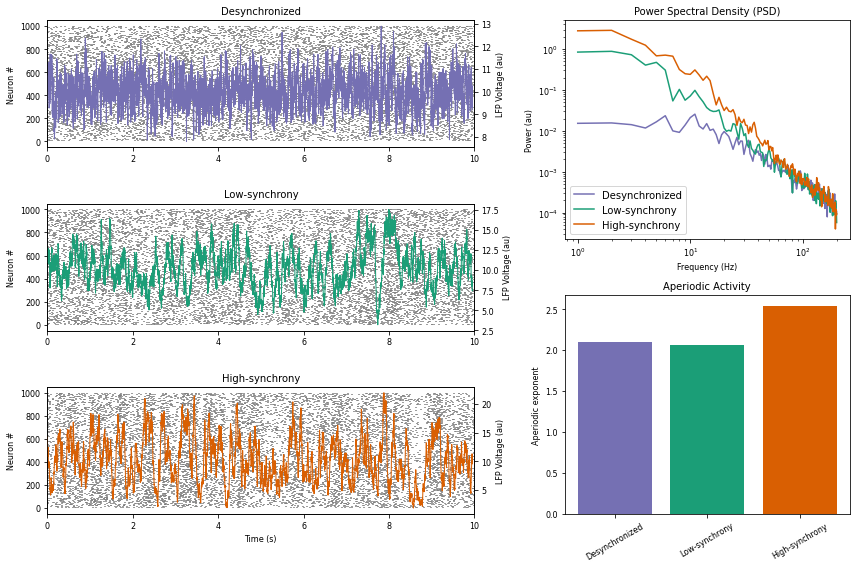

In [19]:
# plot simulation results

# labels
labels = ['Desynchronized', 'Low-synchrony', 'High-synchrony']

# create figure and axes
fig = plt.figure(figsize=[12,8])

# set up gridspec
# spec = gridspec.GridSpec(ncols=5, nrows=6, figure=fig, hspace=0.3, wspace=0.3)
spec = gridspec.GridSpec(ncols=2, nrows=6, figure=fig, width_ratios=[3,2])
ax0 = fig.add_subplot(spec[:2,0])
ax1 = fig.add_subplot(spec[2:4,0])
ax2 = fig.add_subplot(spec[4:6,0])
ax3 = fig.add_subplot(spec[:3,1])
ax4 = fig.add_subplot(spec[3:,1])

# plot spikes and lfp
for ii, ax in enumerate([ax0,ax1,ax2]):
    # plot spikes
    ax.eventplot(pop_spikes[ii], color='grey')
    ax.set(ylabel='Neuron #')
    ax.set_xlim([0,N_SECONDS])
    # plot LFP
    axr = ax.twinx() 
    axr.plot(time[:len(lfps[0])],lfps[ii], linewidth=1, color=colors[ii])
    axr.set(ylabel='LFP Voltage (au)')
ax2.set(xlabel='Time (s)', ylabel='Neuron #')

# plot PSD
for ii in range(len(spectra)):
    ax3.loglog(freq, spectra[ii], color=colors[ii])
    ax3.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
ax3.legend(labels, loc='lower left')

# plot exp barchart
ax4.bar([0,1,2], exp, color=colors)
ax4.set(ylabel='Aperiodic exponent')
ax4.set_xticks([0,1,2])
ax4.set_xticklabels(labels, rotation=30)

# set titles
ax0.set_title('Desynchronized')
ax1.set_title('Low-synchrony')
ax2.set_title('High-synchrony')
ax3.set_title('Power Spectral Density (PSD)')
ax4.set_title('Aperiodic Activity')

# adjust spcing
spec.tight_layout(figure=fig, h_pad=1, w_pad=2)

# save
# plt.savefig(DIR_FIG + '/sim_lfp.png')

#### Repeat simulation across many synchrony levels and regress spike synchrony metrics with LFP exponent

In [23]:
#  repeat with many levels

# coupling_strength = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]#, 1.75, 2]
coupling_strength = np.linspace(0,1,11)
coupling_min = np.zeros(len(coupling_strength)) + 0.2
coupled = np.ones(len(coupling_strength))

# simulate LFP
pop_spikes_x = []
lfps_x = []
pop_rates_x = []
for cp, cs, cm in zip(coupled, coupling_strength, coupling_min):
    print(cs)
    poisson_spikes, pop_rate, lfp, time = simulate_2_process_lfp(cp, cs, cm)
    pop_spikes_x.append(poisson_spikes)
    pop_rates_x.append(pop_rate)
    lfps_x.append(lfp)
    
# compute exp
exp = comp_exp_group(np.vstack(lfps_x), FS)
print(exp)


0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
Running FOOOFGroup across 11 power spectra.
[2.01316646 2.10279983 2.25543883 2.330029   2.35822866 2.59264835
 2.57145244 2.65359942 2.58343634 2.63862966 2.83109489]


In [53]:
# compute SPIKE-syncrony

# init
spk_sync = np.zeros(len(coupling_strength))
spk_dist = np.zeros(len(coupling_strength))
isi_dist = np.zeros(len(coupling_strength))

for ii in range(len(pop_spikes_x)):
    print(ii)
    spike_times = pop_spikes_x[ii]

    n_units = len(spike_times)
    spike_trains = []
    for i_unit in range(n_units):
        if np.ndim(spike_times[i_unit]) == 0: continue
        if len(spike_times[i_unit]) == 0: continue
        sp = spk.SpikeTrain(spike_times[i_unit]*pq.s, [0, N_SECONDS])
        spike_trains.append(sp)

    # compute spike-sync measures
    spk_sync[ii] = spk.spike_sync(spike_trains)
    spk_dist[ii] = spk.spike_distance(spike_trains)
    isi_dist[ii] = spk.isi_distance(spike_trains)

0
1
2
3
4
5
6
7
8
9
10


LinregressResult(slope=-108.46214970416744, intercept=29.33437887927899, rvalue=-0.7469449502037389, pvalue=0.008253643492198565, stderr=32.18218088711105, intercept_stderr=7.977663841464305)
LinregressResult(slope=-45.344150977240446, intercept=15.363925010690432, rvalue=-0.9486111401912092, pvalue=8.591304475822313e-06, stderr=5.042070116218712, intercept_stderr=1.4363964133304608)
LinregressResult(slope=-77.1185183126779, intercept=40.51829030881143, rvalue=-0.8357883947460913, pvalue=0.0013532177981805935, stderr=16.887070595206243, intercept_stderr=8.336531024700813)


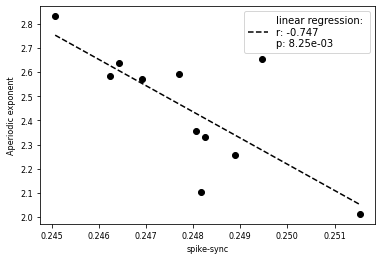

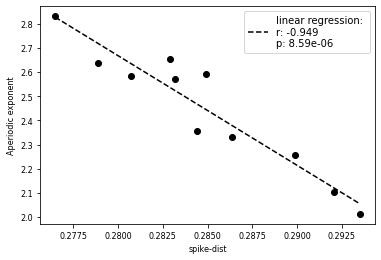

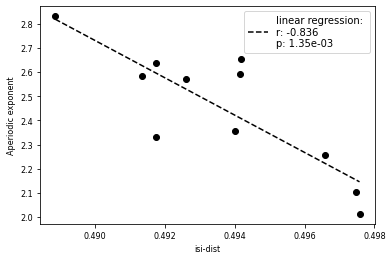

In [56]:
# plot each sync measure
for var, var_str in zip([spk_sync, spk_dist, isi_dist], ['spike-sync','spike-dist','isi-dist']):
    # regression
    lin_reg = linregress(var, exp)
    print(lin_reg)

    # plot regression results
    fig, ax = plt.subplots()
    ax.scatter(var, exp, color='k')

    # label
    ax.set(xlabel=var_str, ylabel='Aperiodic exponent')
    ax.plot([var.min(),var.max()],[var.min()*lin_reg[0]+lin_reg[1],var.max()*lin_reg[0]+lin_reg[1]],
           color='k', linestyle='--', 
            label=f'linear regression: \nr: {np.round(lin_reg[2],3)} \np: {lin_reg[3]:.2e}')

    ax.legend()

In [111]:
# compute correlation/covarience measures

corr_mat = np.zeros([len(coupling_strength),N_NEURONS,N_NEURONS])
cov_mat = np.zeros([len(coupling_strength),N_NEURONS,N_NEURONS])
corr_mu = np.zeros(len(coupling_strength))
cov_mu = np.zeros(len(coupling_strength))

for ii in range(len(coupling_strength)):
    print(ii)
    spike_times = pop_spikes_x[ii]

    n_units = len(spike_times)
    spike_trains = []
    for i_unit in range(n_units):
        sp = neo.SpikeTrain(spike_times[i_unit]*pq.s, N_SECONDS*pq.s)
        spike_trains.append(sp)

    # compute corr
    cov_mat[ii] = covariance(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    cov_mu[ii] = np.mean(cov_mat[ii])
    corr_mat[ii] = correlation_coefficient(BinnedSpikeTrain(spike_trains, bin_size=10*pq.ms))
    corr_mu[ii] = np.mean(corr_mat[ii])


0
1
2
3
4
5
6
7
8
9
10


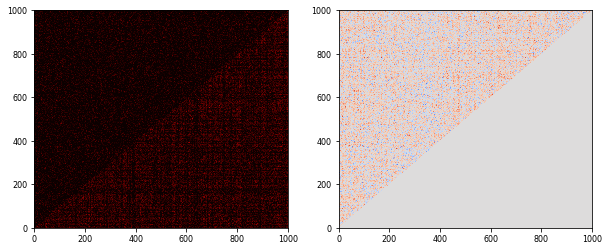

In [112]:
# plot corr

# combine data for compact plotting
temp0 = np.tril(corr_mat[0], -1)
temp1 = np.triu(corr_mat[-1], 1)
corr_mat_comb = temp0+temp1

# compute norm for colorbar
temp = corr_mat[-1]-corr_mat[0]
norm_2s = TwoSlopeNorm(vmin=temp.min(), vcenter=0, vmax=temp.max())
norm = Normalize(vmin=0, vmax=np.max(corr_mat)*0.8)

fig, axes = plt.subplots(1,2,figsize=[10,4])
axes[0].pcolormesh(corr_mat_comb, cmap='hot', norm=norm)
# axes[1].pcolormesh(corr_mat[-1]-corr_mat[0], cmap='coolwarm', norm=norm_2s)
axes[1].pcolormesh(np.tril(corr_mat[-1]-corr_mat[0], -1), cmap='coolwarm', norm=norm_2s)


LinregressResult(slope=28.36907243358067, intercept=1.9399242574303412, rvalue=0.9614378884410298, pvalue=2.4042775753043627e-06, stderr=2.705019075338808, intercept_stderr=0.053324859001683385)
LinregressResult(slope=254.6150378638089, intercept=1.9585254307877906, rvalue=0.9633821953896773, pvalue=1.9103044297375955e-06, stderr=23.6217873344696, intercept_stderr=0.05033942962573263)


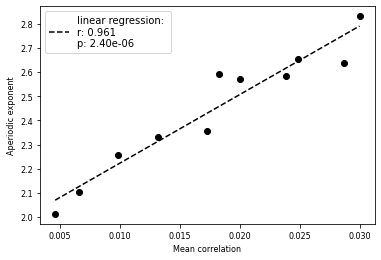

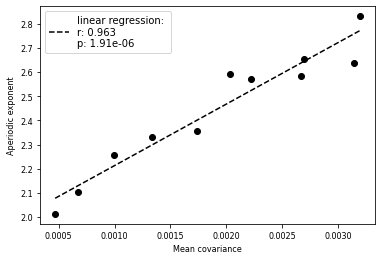

In [114]:
# plot each sync measure
for var, var_str in zip([corr_mu, cov_mu, isi_dist], ['Mean correlation','Mean covariance']):
    # regression
    lin_reg = linregress(var, exp)
    print(lin_reg)

    # plot regression results
    fig, ax = plt.subplots()
    ax.scatter(var, exp, color='k')

    # label
    ax.set(xlabel=var_str, ylabel='Aperiodic exponent')
    ax.plot([var.min(),var.max()],[var.min()*lin_reg[0]+lin_reg[1],var.max()*lin_reg[0]+lin_reg[1]],
           color='k', linestyle='--', 
            label=f'linear regression: \nr: {np.round(lin_reg[2],3)} \np: {lin_reg[3]:.2e}')

    ax.legend()

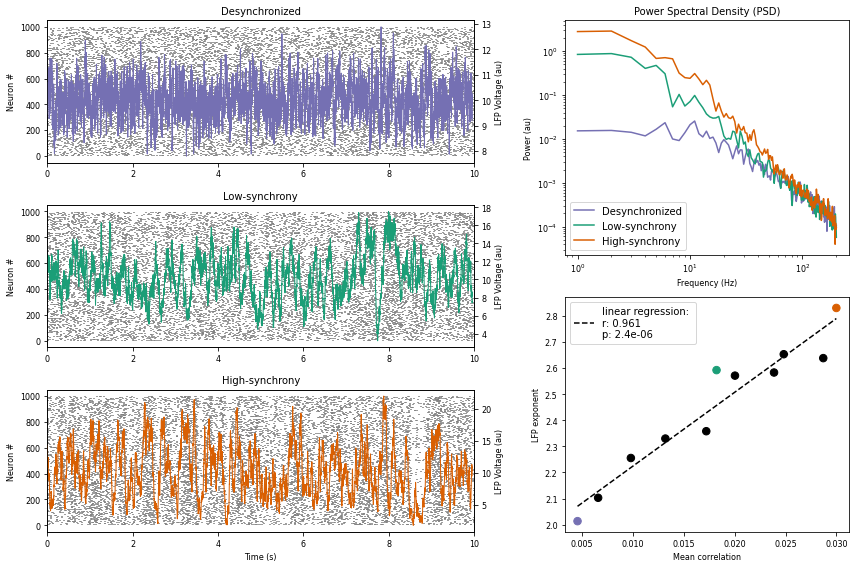

In [117]:
# create figure

# chosse var
sync = corr_mu
sync_label = 'Mean correlation'

# labels
labels = ['Desynchronized', 'Low-synchrony', 'High-synchrony']

# create figure and axes
fig = plt.figure(figsize=[12,8])

# set up gridspec
# spec = gridspec.GridSpec(ncols=5, nrows=6, figure=fig, hspace=0.3, wspace=0.3)
spec = gridspec.GridSpec(ncols=2, nrows=6, figure=fig, width_ratios=[3,2])
ax0 = fig.add_subplot(spec[:2,0])
ax1 = fig.add_subplot(spec[2:4,0])
ax2 = fig.add_subplot(spec[4:6,0])
ax3 = fig.add_subplot(spec[:3,1])
ax4 = fig.add_subplot(spec[3:,1])

# plot spikes and lfp
for ii, ax in enumerate([ax0,ax1,ax2]):
    # plot spikes
    ax.eventplot(pop_spikes[ii], color='grey')
    ax.set(ylabel='Neuron #')
    ax.set_xlim([0,N_SECONDS])
    # plot LFP
    axr = ax.twinx() 
    axr.plot(time[:len(lfps[0])],lfps[ii], linewidth=1, color=colors[ii])
    axr.set(ylabel='LFP Voltage (au)')
ax2.set(xlabel='Time (s)', ylabel='Neuron #')

# plot PSD
for ii in range(len(spectra)):
    ax3.loglog(freq, spectra[ii], color=colors[ii])
    ax3.set(xlabel='Frequency (Hz)', ylabel='Power (au)')
ax3.legend(labels, loc='lower left')

# plot regression results
lin_reg = linregress(sync, exp)
ax4.scatter(sync, exp, color=[colors[0],'k','k','k','k',colors[1],'k','k','k','k',colors[2]], s=56)
ax4.set(xlabel=sync_label, ylabel='LFP exponent')
ax4.plot([sync.min(),sync.max()],[sync.min()*lin_reg[0]+lin_reg[1],sync.max()*lin_reg[0]+lin_reg[1]],
       color='k', linestyle='--', 
        label=f'linear regression: \nr: {np.round(lin_reg[2],3)} \np: {lin_reg[3]:0.1e}')
ax4.legend()

# set titles
ax0.set_title('Desynchronized')
ax1.set_title('Low-synchrony')
ax2.set_title('High-synchrony')
ax3.set_title('Power Spectral Density (PSD)')
# ax4.set_title('Aperiodic Activity')

# adjust spcing
spec.tight_layout(figure=fig, h_pad=1, w_pad=2)

# save
plt.savefig(DIR_FIG + '/panel_1.png')
